# SARIMA Model

## Table of Contents

- **[SARIMA Model](#1)**
- **[Model for Los Angeles County](#2)**
- **[Predicitons](#3)**

In [1]:
# Imports:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

from datetime import timedelta, datetime
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()

%matplotlib inline

In [2]:
#Reading in data
df = pd.read_csv('./Datasets/cleaned_df.csv')

In [3]:
# Change date column to be datetime dtype
df['date'] = pd.to_datetime(df['date'])

In [4]:
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Los Angeles Trending

In [17]:
# graphs to show seasonal_decompose
def seasons(y, n):
    decomposition = seasonal_decompose(y, freq=n)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

<ipython-input-17-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


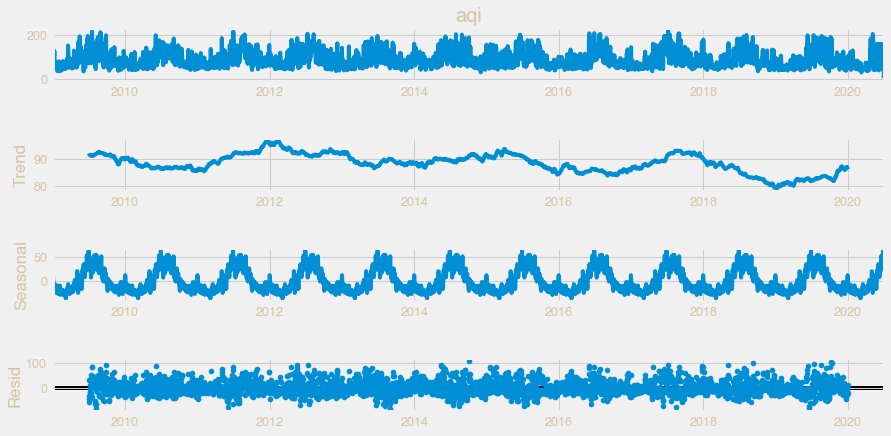

In [18]:
#Year seasonality for LA
seasons(y, 365);

<ipython-input-17-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


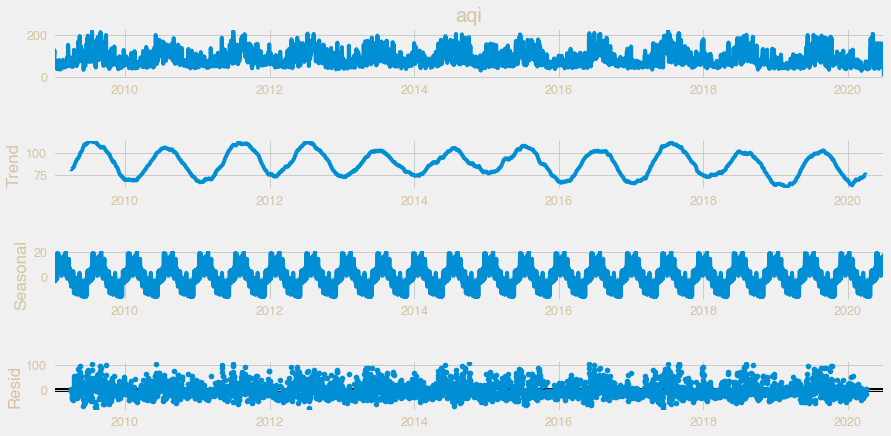

In [19]:
#half a year seasonality in Los Angeles
seasons(y, 180);

<ipython-input-17-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


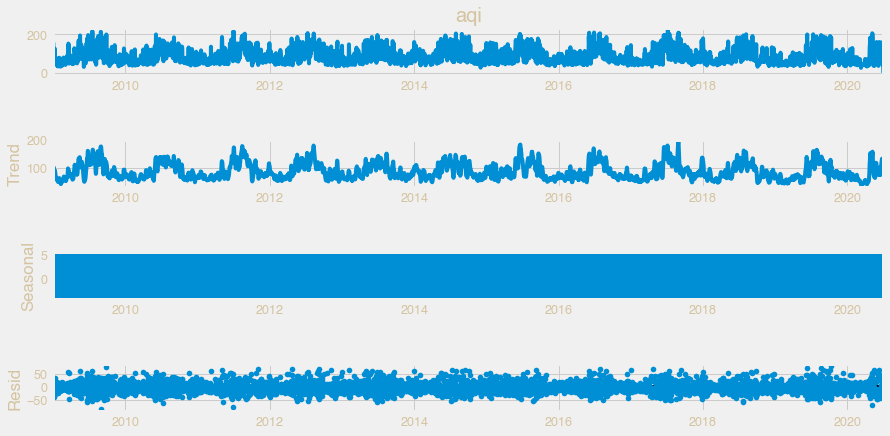

In [20]:
seasons(y, 7)

<ipython-input-14-5b720d689dc9>:5: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(y, freq=n)


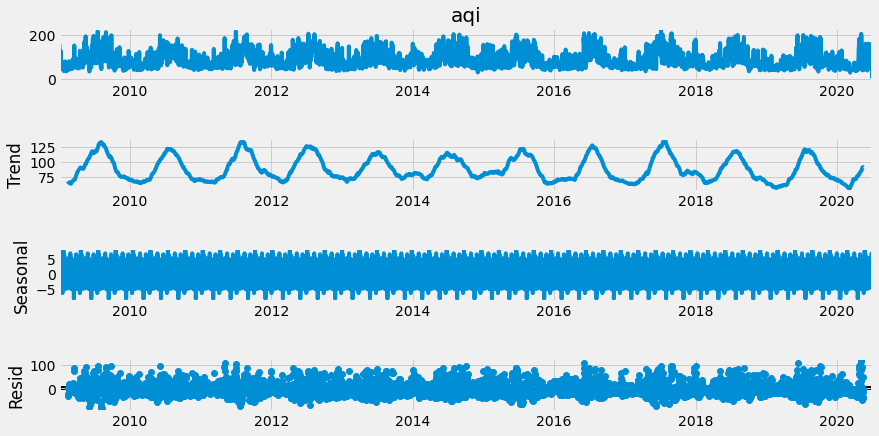

In [18]:
seasons(y, 90)

# Stationarity for LA

In [19]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

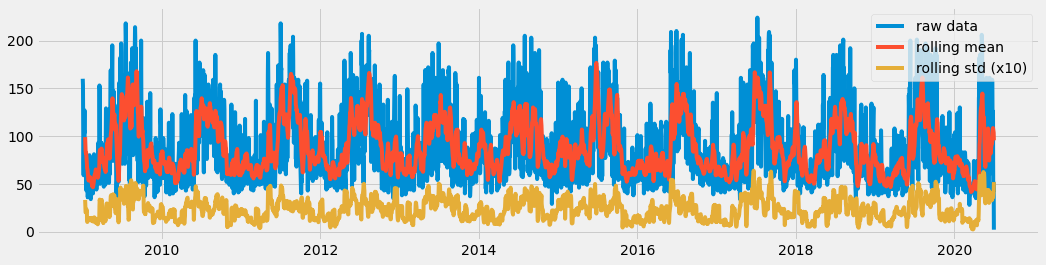

In [20]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

Both the mean and standard deviation for stationary data does not change much over time. But in this case, since the y-axis has such a large scale, we can not confidently conclude that our data is stationary by simply viewing the above graph. Therefore, we should do another test of stationarity.



In [21]:
# Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [22]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -6.569
P-value = 0.000
Critical values :
	1%: -3.4319157624548438 - The data is  stationary with 99% confidence
	5%: -2.8622318677802716 - The data is  stationary with 95% confidence
	10%: -2.5671382871908053 - The data is  stationary with 90% confidence


# Baseline SARIMA Model
---

In [21]:
y

date
2009-01-01    160
2009-01-02    153
2009-01-03    101
2009-01-04     72
2009-01-05     59
             ... 
2020-06-27    119
2020-06-28     42
2020-06-29     44
2020-06-30     51
2020-07-01      2
Name: aqi, Length: 4200, dtype: int64

In [22]:
#defining training and testing set

#Training dates
y_to_train = y['2010-01-01':'2018-12-31'] 

#testing dates
y_to_val = y['2019-01-01':'2019-12-31']

#Number of Data Points for the test
predict_date = len(y) - len(y['2019-01-01':'2019-12-31'])

In [26]:
#runing Sarima model with p, d, q as 0, 0, 0, respectively as a baseline SARIMA model
sarima = sm.tsa.statespace.SARIMAX(endog = y_to_train,
                                   order = (0, 0, 0),
                                   #s is set to 365 for seasoality
                                   seasonal_order = (1,0,1, 365)).fit()
sarima_pred = sarima.predict(start=y_to_val.index[0], end=y_to_val.index[-1])

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [27]:
#AIC score for SARIMA baseline model
sarima.aic

33155.47291268068

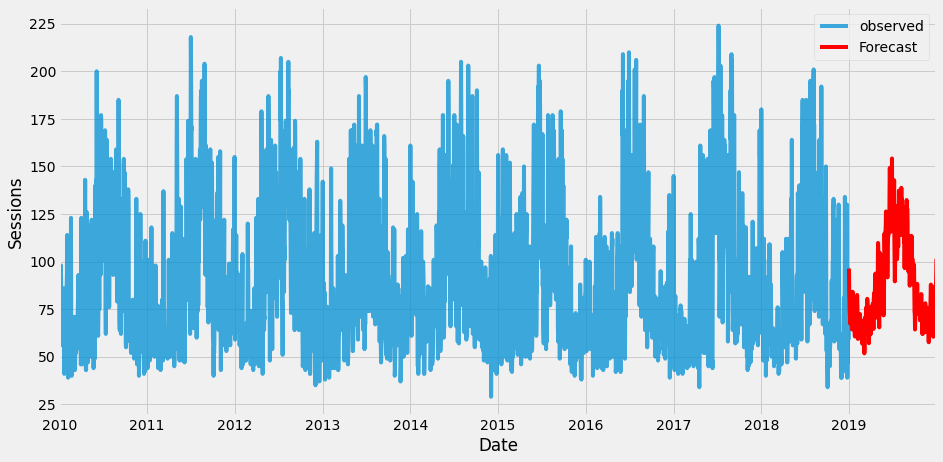

In [33]:
ax = y_to_train.plot(label='observed', alpha=0.75)
sarima_pred.to_frame(name='Forecast').plot(ax=ax, label='Dynamic Forecast', figsize=(14, 7), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Sessions')
#plt.title(f'Dynamic Forecast for {county}')
plt.legend()
plt.show()

In [23]:
# generate predictions off the model
#pred = ar.predict(dynamic=True, start=test.index[0], end=test.index[-1])
    # calculate RMSE and show the score 
rmse = metrics.mean_squared_error(y_to_val, sarima_pred, squared=False)
rmse

NameError: name 'sarima_pred' is not defined

In [35]:
def rmse_ma(true_val, pred, n):
    return (sum((true_val[:n] - pred[:n]) ** 2)/n)**(1/2)

In [40]:
rmse_ma(y_to_val, sarima_pred, 7)

17.094818672772355

# SARIMA MODEL test 2 

In [ ]:
#runing Sarima model with p, d, q as 0, 0, 0, respectively as a baseline SARIMA model
sarima_1 = sm.tsa.statespace.SARIMAX(endog = y_to_train,
                                   order = (1, 0, 0),
                                   #s is set to 365 for seasoality
                                   seasonal_order = (2,0,2, 365)).fit()
sarima_pred = sarima.predict(start=y_to_val.index[0], end=y_to_val.index[-1])

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


# GridSearch for SARIMA Model

---

In [24]:
def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0,2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in pdq]
    mini = float('+inf')
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal
#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [128]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)


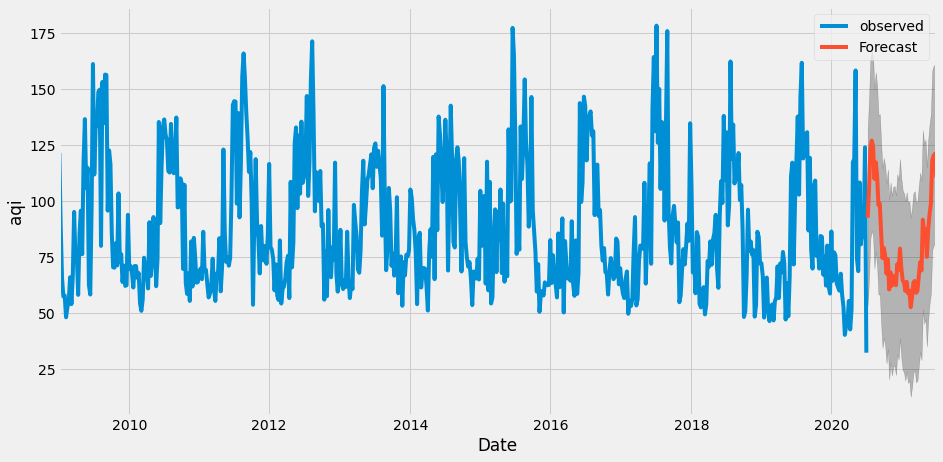

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-07-12,92.53748445,53.40309753,131.67187137
1,2020-07-19,105.50743370,65.50815536,145.50671204
2,2020-07-26,123.32098638,83.27103751,163.37093524
3,2020-08-02,126.96896793,86.91237356,167.02556230
4,2020-08-09,124.44801997,84.38881544,164.50722451


In [129]:
final_table = forecast(model,52,y)
final_table.head()

The red line in the graph represents the expected future data based on the forecasting model we built. The red line represents the average forecasted value for each day, and we would not be surprised to see the actual numbers track to this line for the most part. But there is no guarantee of this!

The gray area above and below the red line represents the 95 percent confidence interval and as with virtually all forecasting models, as the predictions go further into the future, the less confidence we have in our values. In this case, we are 95 percent confident that the actual AQI will fall inside this range. But, there is a chance the actuals could fall completely outside this range also. The larger the future time period for which we want to predict, the larger this confidence range will be (that is, the less precise our forecast is).

# Graph of only Predicted Weeks

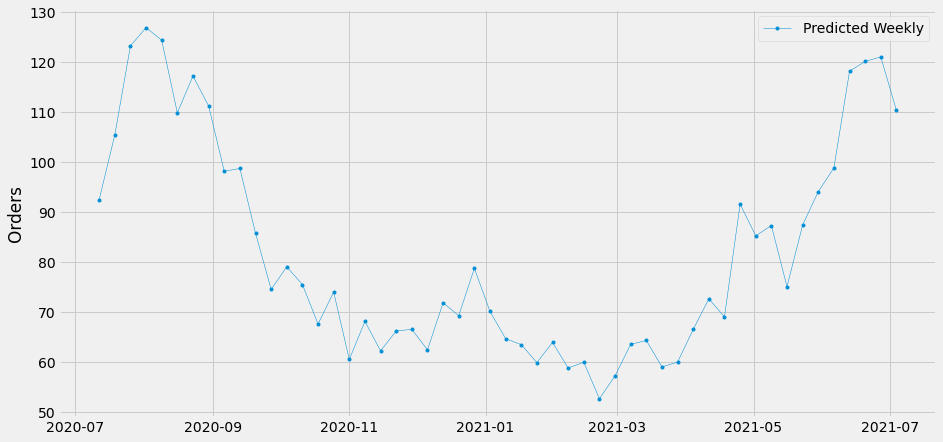

In [133]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
#ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();